# Loglikelihood Functions
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

A set of N trajectories is then generated from this model, from either the same or different initial conditions, across the same or different time-windows. Gaussian noise is then added to all the samples.

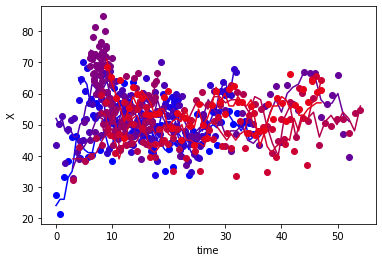

In [2]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
import numpy as np
import pylab as plt
#Create a Model
species = ["X"]
reactions = [(["X"], [], "massaction", {"k":"d1"}), ([], ["X"], "massaction", {"k":"k1"})]
k1 = 10.0
d1 = .2
params = [("k1", k1), ("d1", d1)]
initial_condition = {"X":0}
M = Model(species = species, reactions = reactions, parameters = params, initial_condition_dict = initial_condition)
M.py_initialize()

N = 10 #Number of trajectories
nT = 50 #number of timepoints
noise_std = 5 #Standar deviation of the guassian noise added onto the measurements

MultipleTimepoints = True #Different timepoints for each trajectory?
timepoint_list = []
timepoints = np.linspace(np.random.randint(0, 10), np.random.randint(10, 100), nT)

#Generate Trajectories
R = [] #Results as Pandas Dataframes
Data = [] #Results will become a numpy array
MultipleInitialConditions = True #Different initial conditions for each trajectory?

X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {"X": np.random.randint(0, 100)}
        X0_list.append(initial_condition)
        
    if MultipleTimepoints:
        timepoints = np.linspace(np.random.randint(0, 10, 1), np.random.randint(10, 100, 1), num = 50).flatten()
        timepoint_list.append(timepoints)
    
    M.set_species(initial_condition)
    r = py_simulate_model(timepoints, Model = M, stochastic = True)
    R.append(r)
    noisy_data = r["X"].to_numpy() + np.random.normal(loc = 0, scale = noise_std, size = nT)
    Data.append(noisy_data)

#Plot Results
plt.figure()
Data = np.array(Data)
Data = np.reshape(Data, ( np.shape(Data)+ (1,))) # To make sure Data has shape - N X T X M (where M = len(measured_species))
for n in range(N):
    plt.plot(R[n]['time'], R[n]["X"], color = (n/N, 0, 1-n/N))
    plt.plot(R[n]['time'], Data[n], 'o', color = (n/N, 0, 1-n/N))
_ = plt.xlabel("time")
_ = plt.ylabel("X")

## Data Objects and Loglikelihood Objects for Trajectories
Different kinds of data must be stored in specific kinds of data objects. In turn, each Log-likelihood object is designed to accept a single kind of data object.

DeterministicLikelihood takes a BulkData Data Object. This likelihood sums up the L-norm between N experimental bulk trajectories and a single deterministic ODE simulation for each experimental trajectory.



StochasticTrajectoriesLikelihood takes a StochasticTrajectories Data object. This likelihood sums up the pair-wise L-norm between N experimental stochastic trajectories and N_simulations SSA (non-volume) simulations per experimental trajectory.

### StochasticTrajectories Constructor
*  Timepoints: when the data is sampled. Simulations will return results along the same timepoints.
 *   If each data sample has unique timepoints, timepoints may be passed in as a 2D array of size N x T.
 *    If all data is collected along the same range and number of timepoints, a single vector of T timepoints can be used
*  Data: an N x T x M array. N: number of samples. T: number of timepoints. M: number of species measured
* measured_species: list of M species names corresponding to model species and measurements.
* N: Number of samples.

### StochasticTrajectoriesLikelihood Constructor
* model: A Bioscrape Model
* data: StochasticTrajectories Data Object. If not passed in, can be added via .set_data(StochastiTrajectories) method.
#### Optional:
 * init_state: an initial state dictionary or a list of N (#samples) initial state dictionaries. Defaults to Model's initial state
 * N_simulations: Number of simulations per sample. Defaults to 1.
 * norm_order: What L-norm to use. Defaults to 1.
 * ModelCSimInterface. Generated from Model otherwise.
 * Simulator: How to simulate the model. Defaults to SSASimulator or DelaySSASimulator otherwise.
 
 

In [2]:
#Create LogLikelihoodFunction
from bioscrape.inference import DeterministicLikelihood as DLL
from bioscrape.inference import BulkData
from bioscrape.inference import StochasticTrajectoriesLikelihood as STLL
from bioscrape.inference import StochasticTrajectories


# Create a Data Objects
if MultipleTimepoints:
    DataStoch = StochasticTrajectories(np.array(timepoint_list), Data, ["X"], N)
    DataDet = BulkData(np.array(timepoint_list), Data, ["X"], N)
else:
    DataStoch = StochasticTrajectories(timepoints, Data, ["X"], N)
    DataDet = BulkData(timepoints, Data, ["X"], N)

#Ceate Likelihodo objects:
N_simulations = 3 #Number of simulations per sample to compare to
norm_order = 1 #(integer) Which norm to use: 1-Norm, 2-norm, etc.

#If there are multiple initial conditions in a data-set, should correspond to multiple initial conditions for inference.
#Note len(X0_list) must be equal to the number of trajectories N
if MultipleInitialConditions:    
    LL_stoch = STLL(model = M, init_state = X0_list, data = DataStoch, N_simulations = N_simulations, norm_order = norm_order)
    LL_det = DLL(model = M, init_state = X0_list, data = DataDet, norm_order = norm_order)
    

#Multiple samples with a single initial only require a single initial condition.
else:
    LL_stoch = STLL(model = M, init_state = initial_condition, data = DataStoch, norm_order = norm_order, N_simulations = N_simulations)
    LL_det = DLL(model = M, init_state = initial_condition, data = DataDet, norm_order = norm_order)

print("LL_stoch.N_simulations", LL_stoch.py_get_N_simulations(), "LL_stoch.norm_order", LL_stoch.py_get_norm_order(), "LL_det.norm_order", LL_det.py_get_norm_order())


LL_stoch.N_simulations 3 LL_stoch.norm_order 1 LL_det.norm_order 1


di= 0...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 1...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 2...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 3...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 4...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 5...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 6...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 7...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 8...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 9...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 10...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 11...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 12...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 13...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 di= 14...ki =0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

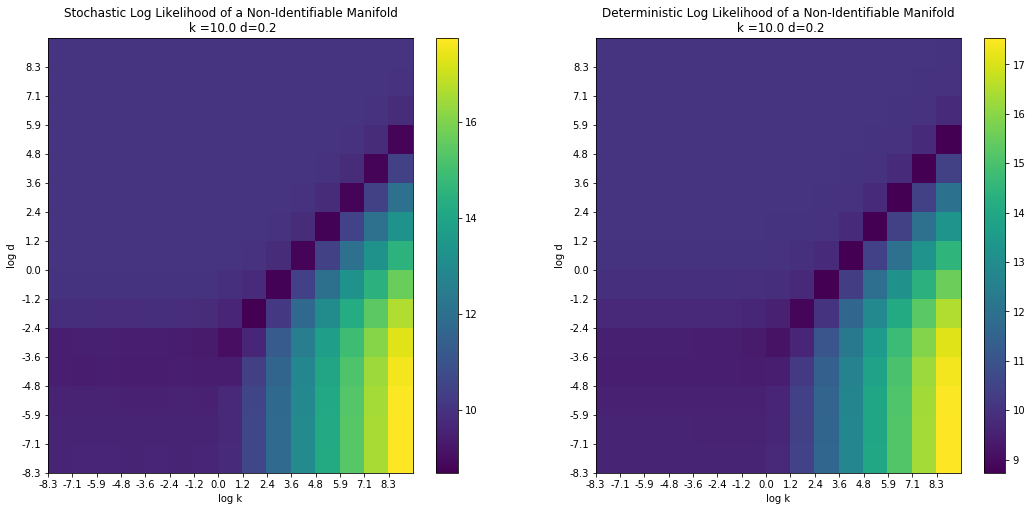

In [3]:
npoints = 15
d_list = np.logspace(-12, 12, base = 2, num = npoints)
k_list = np.logspace(-12, 12, base = 2, num = npoints)
HM_stoch = np.zeros((len(d_list), len(k_list)))
HM_det = np.zeros((len(d_list), len(k_list)))


for di in range(len(d_list)):
    print("di=", di, end = "...ki =")
    for ki in range(len(k_list)):
        print(ki, end = " ")
        LL_stoch.set_init_params({"d1":d_list[di], "k1":k_list[ki]})
        LL_det.set_init_params({"d1":d_list[di], "k1":k_list[ki]})
        
        vs = LL_stoch.py_log_likelihood()
        vd = LL_det.py_log_likelihood()
        
        HM_stoch[di, ki] = -vs
        HM_det[di, ki] = -vd

plt.figure(figsize = (18, 8))
plt.subplot(121)
plt.title("Stochastic Log Likelihood of a Non-Identifiable Manifold\n k ="+str(k1)+" d="+str(d1))
plt.xlabel("log k")
plt.xticks(range(npoints), [round(np.log(k), 1) for k in k_list])
plt.ylabel("log d")
plt.yticks(range(npoints), [round(np.log(d), 1) for d in d_list])
cb = plt.pcolor(np.log(HM_stoch))
_ = plt.colorbar(cb)

plt.subplot(122)
plt.title("Deterministic Log Likelihood of a Non-Identifiable Manifold\n k ="+str(k1)+" d="+str(d1))
plt.xlabel("log k")
plt.xticks(range(npoints), [round(np.log(k), 1) for k in k_list])
plt.ylabel("log d")
plt.yticks(range(npoints), [round(np.log(d), 1) for d in d_list])
cb = plt.pcolor(np.log(HM_det))
_ = plt.colorbar(cb)